In [1]:
# ------------------------------------------------------------
# Proxy setup (DWD): ofsquid.dwd.de:8080
# ------------------------------------------------------------
import os

proxy = "http://ofsquid.dwd.de:8080"

os.environ["http_proxy"]  = proxy
os.environ["https_proxy"] = proxy
os.environ["HTTP_PROXY"]  = proxy
os.environ["HTTPS_PROXY"] = proxy
os.environ["NO_PROXY"]    = "localhost,127.0.0.1,::1"

print("Proxy set to:", proxy)
print("NO_PROXY:", os.environ["NO_PROXY"])

Proxy set to: http://ofsquid.dwd.de:8080
NO_PROXY: localhost,127.0.0.1,::1


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["font.size"] = 11


In [3]:
ZARR_PATH = "data/demo_eu_forecast.zarr"
ds = xr.open_zarr(ZARR_PATH, consolidated=True)
ds

<xarray.Dataset> Size: 18MB
Dimensions:     (valid_time: 41, lat: 121, lon: 181)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 328B 2026-01-10 ... 2026-01-15
  * lat         (lat) float64 968B 35.0 35.31 35.62 35.92 ... 71.38 71.69 72.0
  * lon         (lon) float64 1kB -15.0 -14.72 -14.44 ... 34.44 34.72 35.0
    init_time   datetime64[ns] 8B ...
    lead_time   (valid_time) timedelta64[s] 328B dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    mslp        (valid_time, lat, lon) float32 4MB dask.array<chunksize=(1, 60, 60), meta=np.ndarray>
    t2m         (valid_time, lat, lon) float32 4MB dask.array<chunksize=(1, 60, 60), meta=np.ndarray>
    tp          (valid_time, lat, lon) float32 4MB dask.array<chunksize=(1, 60, 60), meta=np.ndarray>
    u10         (valid_time, lat, lon) float32 4MB dask.array<chunksize=(1, 60, 60), meta=np.ndarray>
    v10         (valid_time, lat, lon) float32 4MB dask.array<chunksize=(1, 60, 60), meta=np.ndarray>
Attributes:
    title:        Synthetic European Forecast Demo
    institution:  Demo dataset for Zarr tutorial
    history:      Created in Notebook 04

In [4]:
# ------------------------------------------------------------
# Offline town database (no internet required)
# ------------------------------------------------------------

TOWNS = {
    "Berlin":  (52.5200, 13.4050),
    "Hamburg": (53.5511, 9.9937),
    "Munich":  (48.1372, 11.5756),
    "Cologne": (50.9375, 6.9603),
    "Paris":   (48.8566, 2.3522),
    "Vienna":  (48.2082, 16.3738),
    "Rome":    (41.9028, 12.4964),
    "Madrid":  (40.4168, -3.7038),
    "London":  (51.5074, -0.1278),
}

sorted(TOWNS.keys())

['Berlin',
 'Cologne',
 'Hamburg',
 'London',
 'Madrid',
 'Munich',
 'Paris',
 'Rome',
 'Vienna']

In [5]:
# ------------------------------------------------------------
# Pick a town and extract point forecast
# ------------------------------------------------------------

town = "Berlin"  # change here
lat0, lon0 = TOWNS[town]

pt = ds.sel(lat=lat0, lon=lon0, method="nearest")

print("Town:", town, "target:", (lat0, lon0))
print("Nearest grid:", (float(pt.lat.values), float(pt.lon.values)))

pt

Town: Berlin target: (52.52, 13.405)
Nearest grid: (52.575, 13.333333333333336)


<xarray.Dataset> Size: 2kB
Dimensions:     (valid_time: 41)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 328B 2026-01-10 ... 2026-01-15
    init_time   datetime64[ns] 8B ...
    lat         float64 8B 52.58
    lead_time   (valid_time) timedelta64[s] 328B dask.array<chunksize=(1,), meta=np.ndarray>
    lon         float64 8B 13.33
Data variables:
    mslp        (valid_time) float32 164B dask.array<chunksize=(1,), meta=np.ndarray>
    t2m         (valid_time) float32 164B dask.array<chunksize=(1,), meta=np.ndarray>
    tp          (valid_time) float32 164B dask.array<chunksize=(1,), meta=np.ndarray>
    u10         (valid_time) float32 164B dask.array<chunksize=(1,), meta=np.ndarray>
    v10         (valid_time) float32 164B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    title:        Synthetic European Forecast Demo
    institution:  Demo dataset for Zarr tutorial
    history:      Created in Notebook 04

In [6]:
# ------------------------------------------------------------
# Create a clean timeseries table
# ------------------------------------------------------------

df = pd.DataFrame({
    "valid_time": pd.to_datetime(pt["valid_time"].values),
    "lead_h": pt["lead_time"].values.astype(int),
    "t2m_C": pt["t2m"].values,
    "wind_ms": np.sqrt(pt["u10"].values**2 + pt["v10"].values**2),
    "mslp_hPa": pt["mslp"].values,
    "tp_mm": pt["tp"].values,
})

df.head()

,valid_time,lead_h,t2m_C,wind_ms,mslp_hPa,tp_mm
0,2026-01-10 00:00:00,0,6.229954,6.295579,1015.264343,0.007674
1,2026-01-10 03:00:00,10800,6.654215,6.360413,1014.963684,0.008522
2,2026-01-10 06:00:00,21600,7.314708,6.429814,1014.639343,0.017894
3,2026-01-10 09:00:00,32400,8.138855,6.500622,1014.276184,0.024785
4,2026-01-10 12:00:00,43200,8.887595,6.569792,1013.846802,0.041911


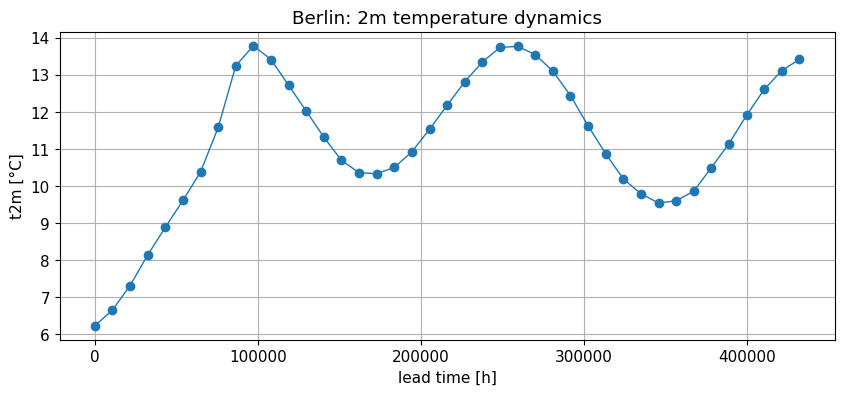

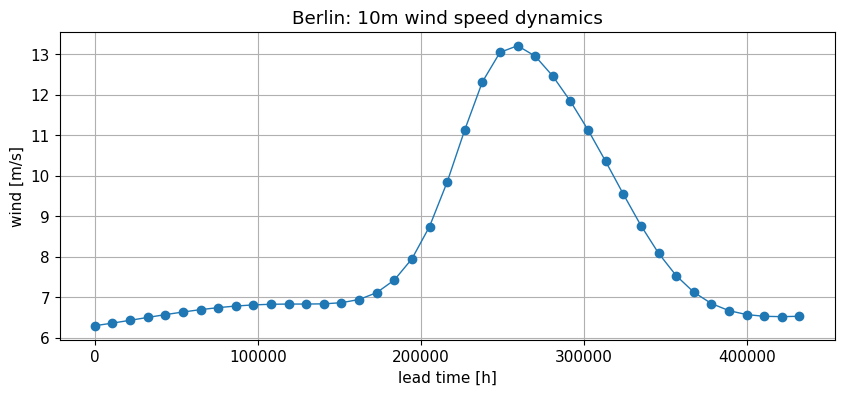

In [10]:
fig, ax = plt.subplots()

ax.plot(df["lead_h"], df["t2m_C"], marker="o", linewidth=1)
ax.set_title(f"{town}: 2m temperature dynamics")
ax.set_xlabel("lead time [h]")
ax.set_ylabel("t2m [°C]")
ax.grid(True)
plt.savefig("zarr_t2m_dynamics.png")
plt.show()

fig, ax = plt.subplots()
ax.plot(df["lead_h"], df["wind_ms"], marker="o", linewidth=1)
ax.set_title(f"{town}: 10m wind speed dynamics")
ax.set_xlabel("lead time [h]")
ax.set_ylabel("wind [m/s]")
ax.grid(True)
plt.savefig("zarr_wind_dynamics.png")
plt.show()

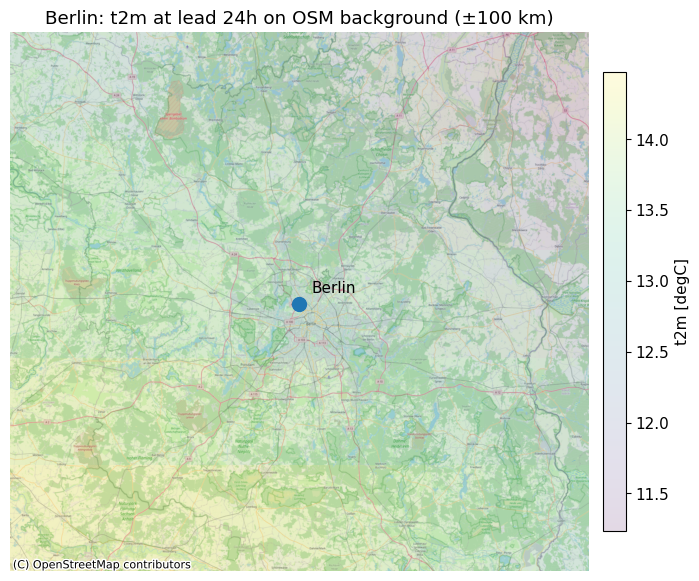

In [8]:
# ------------------------------------------------------------
# OSM basemap (OpenStreetMap) + overlay t2m in a 100 km box
# (no Cartopy)
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# basemap tiles (OpenStreetMap)
try:
    import contextily as ctx
except ImportError as e:
    raise ImportError(
        "Missing package: contextily\n"
        "Install with:\n"
        "  pip install contextily\n"
        "or (conda):\n"
        "  conda install -c conda-forge contextily"
    ) from e

from pyproj import Transformer


# -----------------------------
# settings
# -----------------------------
lead_plot_h = 24
R_km = 100.0

# -----------------------------
# robust lead time handling
# -----------------------------
lead_raw = ds["lead_time"].values
if np.issubdtype(lead_raw.dtype, np.timedelta64):
    lead_h = (lead_raw / np.timedelta64(1, "h")).astype(int)
else:
    lead_h = lead_raw.astype(int)

i = int(np.argmin(np.abs(lead_h - lead_plot_h)))
t2m_map = ds["t2m"].isel(valid_time=i)

# town coords (nearest gridpoint)
latc = float(pt.lat.values)
lonc = float(pt.lon.values)

# -----------------------------
# km -> degrees for slicing
# -----------------------------
dlat = R_km / 111.0
dlon = R_km / (111.0 * np.cos(np.deg2rad(latc)))

lon_min, lon_max = lonc - dlon, lonc + dlon
lat_min, lat_max = latc - dlat, latc + dlat

# slice for speed
t2m_local = t2m_map.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

# -----------------------------
# Reproject to WebMercator for OSM tiles
# EPSG:4326 -> EPSG:3857
# -----------------------------
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

lon1d = t2m_local["lon"].values
lat1d = t2m_local["lat"].values

# build projected grid edges for pcolormesh
# compute edges from centers
def edges_from_centers(x):
    x = np.asarray(x)
    dx = np.diff(x)
    dx0 = dx[0]
    dx1 = dx[-1]
    edges = np.empty(x.size + 1, dtype=float)
    edges[1:-1] = 0.5 * (x[:-1] + x[1:])
    edges[0]    = x[0] - 0.5 * dx0
    edges[-1]   = x[-1] + 0.5 * dx1
    return edges

lon_edges = edges_from_centers(lon1d)
lat_edges = edges_from_centers(lat1d)

# project edges (mesh)
LON_E, LAT_E = np.meshgrid(lon_edges, lat_edges, indexing="xy")
XE, YE = transformer.transform(LON_E, LAT_E)

# town projected
xc, yc = transformer.transform(lonc, latc)

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(9, 7))

# set map extent in WebMercator
xmin, xmax = XE.min(), XE.max()
ymin, ymax = YE.min(), YE.max()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# add OSM background tiles
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)

# overlay temperature
im = ax.pcolormesh(
    XE, YE,
    t2m_local.values,
    shading="auto",
    alpha=0.15,   # transparency
)

# town marker
ax.scatter([xc], [yc], s=100)
ax.text(xc + 0.02*(xmax-xmin), yc + 0.02*(ymax-ymin), town)

ax.set_title(f"{town}: t2m at lead {lead_h[i]}h on OSM background (±{int(R_km)} km)")
cb = plt.colorbar(im, ax=ax, shrink=0.85, pad=0.02)
cb.set_label(f"t2m [{t2m_map.attrs.get('units','')}]")

# nicer axes
ax.set_axis_off()
plt.savefig("zarr_map_Berlin.png")
plt.show()
